In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.models as models

import cv2
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import heapq
import itertools

In [2]:
dir = 'data/'
balance_dir = 'balanced_data/'

classes = os.listdir(dir)
num_classes = len(classes)

print(
    f'Number of classes: {num_classes}',
    f'\nClasses: {classes}'
)

Number of classes: 4 
Classes: ['cloudy', 'rain', 'shine', 'sunrise']


In [3]:
print("--------data--------")
# check the number of images in each class
for cls in classes:
    print(f'{cls}: {len(os.listdir(balance_dir + cls))}')

--------data--------
cloudy: 1200
rain: 1200
shine: 1200
sunrise: 1200


In [4]:
import os
import imghdr
import shutil

def delete_irrelevant_files(directory, classes):
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        with os.scandir(class_dir) as entries:
            for entry in entries:
                # Delete directories
                if entry.is_dir():
                    print(f'Deleting directory: {entry.path}')
                    shutil.rmtree(entry.path)

                # Check if the file is empty and delete it
                elif os.path.getsize(entry.path) == 0:
                    print(f'Deleting empty file: {entry.path}')
                    os.remove(entry.path)

                # Check if the file is not an image and delete it
                elif not imghdr.what(entry.path):
                    print(f'Deleting non-image file: {entry.path}')
                    os.remove(entry.path)

print("--------data--------")
delete_irrelevant_files(balance_dir, classes)

--------data--------


In [5]:
images_ = []
for cls in classes:
    img = cv2.imread(balance_dir + cls + '/' + os.listdir(balance_dir + cls)[-2])
    #img = Image.open(dir + cls + '/' + os.listdir(dir + cls)[0])
    images_.append(img)

images = []
for cls in classes:
    img = cv2.imread(balance_dir + cls + '/' + os.listdir(balance_dir + cls)[0])
    #img = Image.open(dir + cls + '/' + os.listdir(dir + cls)[0])
    images.append(img)

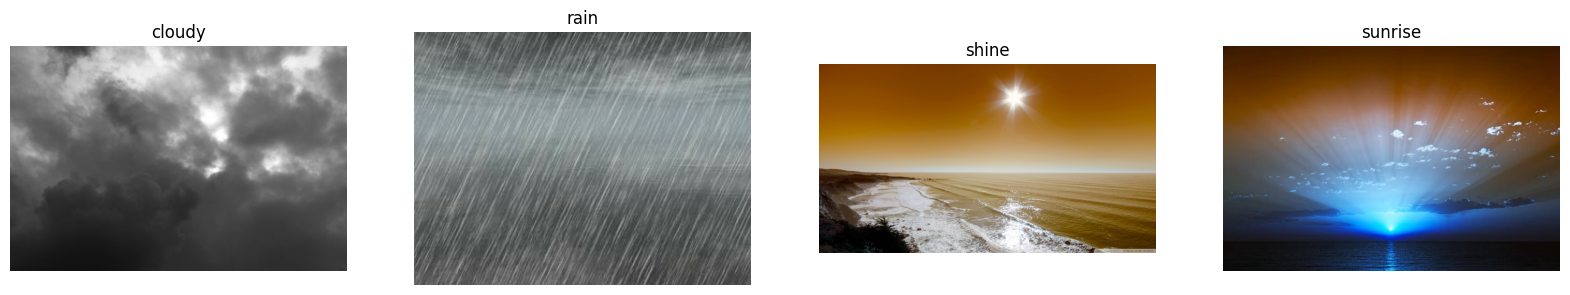

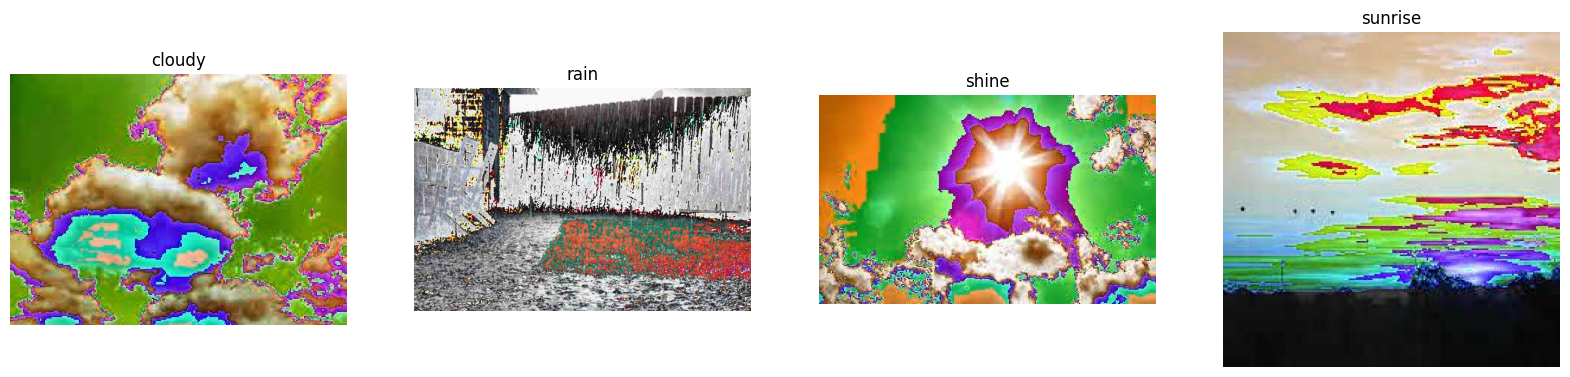

In [6]:
%matplotlib inline

fig, axes = plt.subplots(1, 4, figsize=(20, 20))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(classes[i])
    ax.axis('off')


fig, axes = plt.subplots(1, 4, figsize=(20, 20))
for i, ax in enumerate(axes):
    ax.imshow(images_[i])
    ax.set_title(classes[i])
    ax.axis('off')

In [7]:
class WeatherDataset(Dataset):
    def __init__(self, directory, classes, transform=None):
        self.directory = directory
        self.classes = classes
        self.transform = transform
        self.data = []

        for cls in classes:
            class_dir = os.path.join(directory, cls)
            with os.scandir(class_dir) as entries:
                for entry in entries:
                    self.data.append((entry.path, cls))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        label_idx = self.classes.index(label)  # Convert the label to its index
        return image, label_idx


In [8]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Load the WeatherDataset
dataset = WeatherDataset(directory=balance_dir, classes=['cloudy', 'rain', 'shine', 'sunrise'], transform=transform)                         
print(f'Test dataset size: {len(dataset)}')

Test dataset size: 4800


In [9]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
class Flatten(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

class UnFlatten(nn.Module):
    def __init__(self, h_dim):
        super(UnFlatten, self).__init__()
        self.h_dim = h_dim

    def forward(self, input):
        return input.view(input.size(0), self.h_dim, 1, 1)


In [12]:
def calc_output_size(input_size, conv_layers):
    x = torch.zeros(1, *input_size)
    for layer in conv_layers:
        x = layer(x)
    return x.size(1) * x.size(2) * x.size(3)

In [26]:
class ConvVAE(nn.Module):
  def __init__(self, image_channels=3, z_dim=32):
    super(ConvVAE, self).__init__()

    self.h_dim = 256 * 16 * 16
    self.z_dim = z_dim
    self.feature_size = 16

    self.encoder = nn.Sequential(
      nn.Conv2d(image_channels, 32, kernel_size=3, stride=1, padding=1, bias=False),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Dropout(0.5),

      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Dropout(0.25),

      nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Dropout(0.125),

      nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Dropout(0.075),
    )
      
    self.fc1 = nn.Linear(self.h_dim, z_dim)
    self.fc2 = nn.Linear(self.h_dim, z_dim)
    self.fc3 = nn.Linear(z_dim, self.h_dim)
      
    self.decoder = nn.Sequential(
      UnFlatten(self.h_dim),

      nn.ConvTranspose2d(self.h_dim, 128, kernel_size=3, stride=1, padding=1, bias=False),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Dropout(0.25),

      nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1, bias=False),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Dropout(0.125),

      nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Dropout(0.075),

      # Start of the upscaling layers to reach the desired output size (64, 64)
      nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
      nn.ReLU(inplace=True),
      nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),

      nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
      nn.AdaptiveAvgPool2d((64, 64)),
      nn.Sigmoid()
    )

  def reparameterize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    # return torch.normal(mu, std)
    esp = torch.randn(*mu.size())
    esp = esp.to(device)
    z = mu + std * esp
    return z
    
  def bottleneck(self, h):
    mu, logvar = self.fc1(h), self.fc2(h)
    z = self.reparameterize(mu, logvar)
    return z, mu, logvar

  def encode(self, x):
    h = self.encoder(x)
    z, mu, logvar = self.bottleneck(h)
    return z, mu, logvar

  def decode(self, z):
    z = self.fc3(z)
    z = self.decoder(z)
    return z

  def forward(self, x):
    # Encoding
    for layer in self.encoder:
      x = layer(x)
      print("Encoder:", x.shape)  # Print the shape after each encoder layer

    x = x.view(x.size(0), -1)
    print("Flatten:", x.shape)  # Print the shape after Flatten

    mu, logvar = self.fc1(x), self.fc2(x)
    print("FC1 (mu):", mu.shape, "FC2 (logvar):", logvar.shape)  # Print the shapes after FC1 and FC2
    
    z = self.reparameterize(mu, logvar)
    
    z_decoded = self.fc3(z)
    print("FC3 (z_decoded):", z_decoded.shape)  # Print the shape after FC3
    
    z_decoded = z_decoded.view(z_decoded.size(0), 256, self.feature_size, self.feature_size)  # Use 256 instead of self.h_dim
    print("UnFlatten:", z_decoded.shape)  # Print the shape after UnFlatten

    # Decoding
    for layer in self.decoder:
      z_decoded = layer(z_decoded)
      print("Decoder:", z_decoded.shape)  # Print the shape after each decoder layer

    return z_decoded, mu, logvar

model = ConvVAE()
model.cuda(device)

ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.125, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (13): ReLU(inplace=True)
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0

In [27]:
#save the model as txt
with open('model.txt', 'w') as f:
    print(model, file=f)

In [28]:
import torch.optim as optim
import torch.nn.functional as F

print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

Train dataset size: 3840
Test dataset size: 960


In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0001)

def loss_fn(recon_x, x, mu, logvar):
  BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
  # BCE = F.mse_loss(recon_x, x, size_average=False)

  # see Appendix B from VAE paper:
  # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
  # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

  return BCE + KLD, BCE, KLD

In [30]:
import math
import time
from IPython.display import clear_output

def plot_images(images, labels, no):  
  rows = int(math.sqrt(no))
  plt.ion()
  fig = plt.figure(figsize=(rows*2, rows*2))      
  for idx in np.arange(no):
      ax = fig.add_subplot(rows, int(no/rows), idx+1, xticks=[], yticks=[])
      imshow(images[idx])
      ax.set_title(classes[labels[idx]]) 
  time.sleep(0.1)
  plt.pause(0.0001)

def imshow(img):    
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

#classes
classes = ['cloudy', 'rain', 'shine', 'sunrise']

Epoch: 1 Training Loss: 0.000


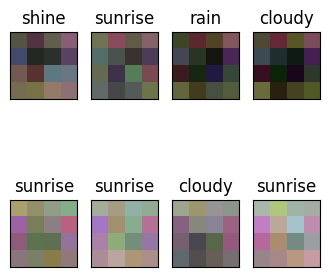

In [31]:
epochs = 1

for epoch in range(epochs):    
    train_loss = 0.0    
    for data in train_loader:        
        images, labels = data        
        # Load one batch of images
        images, _ = next(iter(train_loader))
        images = images.to(device)

        # Run the training loop once
        optimizer.zero_grad()
        generated, mu, logvar = model(images)
        loss, bce, kld = loss_fn(generated, images, mu, logvar)
        loss.backward()
        optimizer.step()
            
    train_loss = train_loss/len(train_loader)
    clear_output()
    print(f'Epoch: {epoch+1} Training Loss: {train_loss:.3f}')    
    num_images = generated.size(0)
    plot_images(generated.cpu().data, labels, num_images)

In [ ]:
from torch.cuda.amp import GradScaler, autocast

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
num_epochs = 100

train_loss_list = []
val_loss_list = []
# Training loop
for epoch in range(1, num_epochs + 1):
    
    train_loss = train(model, train_loader, optimizer, epoch)
    train_loss_list.append(train_loss)
    
    val_loss = test(model, test_loader)
    val_loss_list.append(val_loss)
    
    scheduler.step(val_loss)

In [ ]:
import pandas as pd
import seaborn as sns

# Convert the lists to DataFrames
train_loss_list = pd.DataFrame({'Epoch': range(len(train_loss_list)), 'Loss': train_loss_list, 'Type': 'Train'})
val_loss_list = pd.DataFrame({'Epoch': range(len(val_loss_list)), 'Loss': val_loss_list, 'Type': 'Validation'})

# Concatenate the DataFrames
loss_df = pd.concat([train_loss_list, val_loss_list])

# Plot the graph
sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
sns.lineplot(data=loss_df, x='Epoch', y='Loss', hue='Type')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the graph to a file
plt.savefig('loss_graph_Adam.png', dpi=300)

plt.show()

In [ ]:
# define a function to check pytorch version
def check_pytorch_version():
    if torch.__version__ >= '1.6.0':
        return True
    else:
        return False
    
# define a function to check cuda version
def check_cuda_version():
    if torch.cuda.is_available():
        return True
    else:
        return False
    
# define a function to check cudnn version
def check_cudnn_version():
    if check_cuda_version():
        if torch.backends.cudnn.enabled:
            return True
        else:
            return False
    else:
        return False
    
# define a function to check if the system is ready for training
def check_system():
    if check_pytorch_version():
        print('PyTorch version: {}'.format(torch.__version__))
    else:
        print('PyTorch version: {} (update required)'.format(torch.__version__))
        
    if check_cuda_version():
        print('CUDA version: {}'.format(torch.version.cuda))
    else:
        print('CUDA version: {} (install CUDA to enable GPU training)'.format(torch.version.cuda))
        
    if check_cudnn_version():
        print('cuDNN version: {}'.format(torch.backends.cudnn.version()))
    else:
        print('cuDNN version: {} (install cuDNN to enable GPU training)'.format(torch.backends.cudnn.version()))

check_system()

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!pip install cumm-cu118